In [1]:
# pptx파일을 읽어들이는 python-pptx 라이브러리를 google colab 환경에서 설치
!pip install python-pptx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 17.3 MB/s eta 0:00:00


In [2]:
# matplotlib plot에서 한글을 인식할 수 있도록 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (54.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120901 files and direc

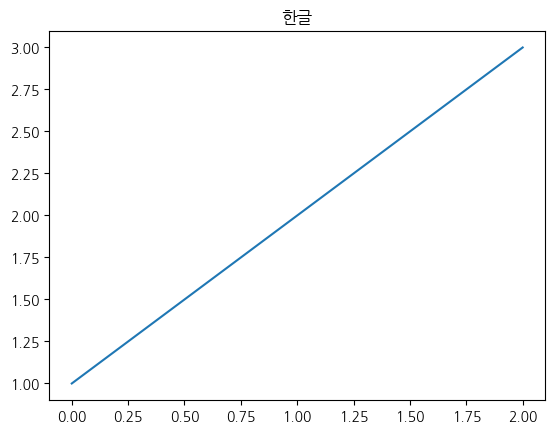

In [1]:
# 폰트 설치 후 런타임 재실행하여 테스트
import matplotlib.pyplot as plt
plt.rc("font", family="NanumGothic")

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

In [2]:
# google drive와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE_TYPE

# 2020년 1월부터 2022년 12월까지 YYYYMM 형태로 리스트에 저장
YYYYMM = []
for i in [2020, 2021, 2022]:
  for j in range(1, 13):
    YYYYMM.append(f'{i}{j:02d}')

slides = [10, 20, 32, 51, 52, 55, 56, 57, 58] # 0-indexing 되어있는 pptx파일 슬라이드 중 가공하고자 하는 인덱스

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/semiPJT/제주DB/'

df_dict = {}

for t in YYYYMM:
  parsed = Presentation(DATA_PATH + t + '.pptx')  # pptx파일 불러오기
  for page in slides:
    slide = parsed.slides[page] # pptx파일에서 가공하고자 하는 슬라이드 순회하며 불러오기
    idx = 0 # page별로 table이 여러 개 있는 경우 구분을 위해 별도 idx 설정
    for shape in slide.shapes:
      table_data = []
      if shape.shape_type == MSO_SHAPE_TYPE.TABLE:  # 슬라이드 내 객체의 type이 table인 경우 추출
        idx += 1
        row_count = len(shape.table.rows)
        col_count = len(shape.table.columns)
        for r in range(0, row_count):
          row = []
          for c in range(0, col_count):
            cell = shape.table.cell(r, c)
            row.append(cell.text) # table의 (r, c)위치에 존재하는 text를 row 리스트에 저장
          table_data.append(row)  # r과 c를 순회하며 row 리스트를 table_data 리스트에 저장하여 2d-array 생성
        df_temp = pd.DataFrame(table_data)
        df_dict[f'{t}_{page+1:02d}_{idx}'] = df_temp  # df_dict에 '시기_슬라이드번호_idx'를 key로 가지도록 dataframe 저장
# df_dict.keys()

In [4]:
# 추출한 테이블마다 원하는 대로 데이터 전처리하도록 함수 생성

def pre_total(df, t):
  df = df.loc[2:16, [3, 7]]
  df.reset_index(drop = True, inplace = True)
  df.reset_index(inplace = True)
  df.rename(columns = {'index': '순위', 3: '블록명', 7: '비율'}, inplace = True)
  df['순위'] = df['순위'] + 1
  df['시기'] = t
  return df

def pre_partial(df, t):
  df = df.loc[2:16, [2, 6]]
  df.reset_index(drop = True, inplace = True)
  df.reset_index(inplace = True)
  df.rename(columns = {'index': '순위', 2: '블록명', 6: '비율'}, inplace = True)
  df['순위'] = df['순위'] + 1
  df['시기'] = t
  return df

def pre_male(df, t):
  df = df.loc[2:, [0, 2, 3]]
  df.reset_index(drop = True, inplace = True)
  df.rename(columns = {0: '순위', 2: '블록명', 3: '남성_방문객_수'}, inplace = True)
  df['순위'] = df['순위'].astype('int64')
  df['시기'] = t
  return df

def pre_female(df, t):
  df = df.loc[2:, [0, 2, 5]]
  df.reset_index(drop = True, inplace = True)
  df.rename(columns = {0: '순위', 2: '블록명', 5: '여성_방문객_수'}, inplace = True)
  df['순위'] = df['순위'].astype('int64')
  df['시기'] = t
  return df

def pre_age(df, t):
  div = df.loc[0, 3]
  df = df.loc[2:, [0, 2, 3]]
  df.reset_index(drop = True, inplace = True)
  df.rename(columns = {0: '순위', 2: '블록명', 3: f'{div} 방문객 수'}, inplace = True)
  df['순위'] = df['순위'].astype('int64')
  df['시기'] = t
  return df

In [5]:
slides_1 = [10, 20, 32, 51, 52]

pre_df_dict = {}

for t in YYYYMM:
  for page in slides:
    if page in slides_1:
      df_temp = df_dict[f'{t}_{page+1:02d}_1']
      if page == 10:
        df_temp = pre_total(df_temp, t)
        pre_df_dict[f'{t}_{page+1:02d}'] = df_temp
      elif page == 20 or 32:
        df_temp = pre_partial(df_temp, t)
        pre_df_dict[f'{t}_{page+1:02d}'] = df_temp
      elif page == 51:
        df_temp = pre_male(df_temp, t)
        pre_df_dict[f'{t}_{page+1:02d}'] = df_temp
      else:
        df_temp = pre_female(df_temp, t)
        pre_df_dict[f'{t}_{page+1:02d}'] = df_temp
    else:
      df_temp = df_dict[f'{t}_{page+1:02d}_2']
      df_temp = pre_age(df_temp, t)
      pre_df_dict[f'{t}_{page+1:02d}'] = df_temp

# pre_df_dict.keys()

In [6]:
total_df = {}

visit_ratio_total = []
visit_ratio_jejusi = []
visit_ratio_seogwiposi = []
visit_count_male = []
visit_count_female = []
visit_count_below20 = []
visit_count_2030 = []
visit_count_4060 = []
visit_count_above70 = []

# 전 기간 데이터를 하나의 dataframe으로 병합
for t in YYYYMM:
  for page in slides:
    df_temp = pre_df_dict[f'{t}_{page+1:02d}']
    if page == 10:
      visit_ratio_total.append(df_temp)
    elif page == 20:
      visit_ratio_jejusi.append(df_temp)
    elif page == 32:
      visit_ratio_seogwiposi.append(df_temp)
    elif page == 51:
      visit_count_male.append(df_temp)
    elif page == 52:
      visit_count_female.append(df_temp)
    elif page == 55:
      visit_count_below20.append(df_temp)
    elif page == 56:
      visit_count_2030.append(df_temp)
    elif page == 57:
      visit_count_4060.append(df_temp)
    else:
      visit_count_above70.append(df_temp)

ratio_total = pd.concat(visit_ratio_total).reset_index(drop = True)
ratio_jejusi = pd.concat(visit_ratio_jejusi).reset_index(drop = True)
ratio_seogwiposi = pd.concat(visit_ratio_seogwiposi).reset_index(drop = True)
count_male = pd.concat(visit_count_male).reset_index(drop = True)
count_female = pd.concat(visit_count_female).reset_index(drop = True)
count_below20 = pd.concat(visit_count_below20).reset_index(drop = True)
count_2030 = pd.concat(visit_count_2030).reset_index(drop = True)
count_4060 = pd.concat(visit_count_4060).reset_index(drop = True)
count_above70 = pd.concat(visit_count_above70).reset_index(drop = True)

## 활용 예시

In [ ]:
ratio_total

,순위,블록명,비율,시기
0,1,용담2,6.9,202001
1,2,연동,4.4,202001
2,3,노형,4.4,202001
3,4,예래해안,4.2,202001
4,5,애월중산간(저),4.1,202001
...,...,...,...,...
535,11,안덕해안,2.6,202212
536,12,중문해안,2.2,202212
537,13,표선해안,2.2,202212
538,14,안덕중산간,2.1,202212


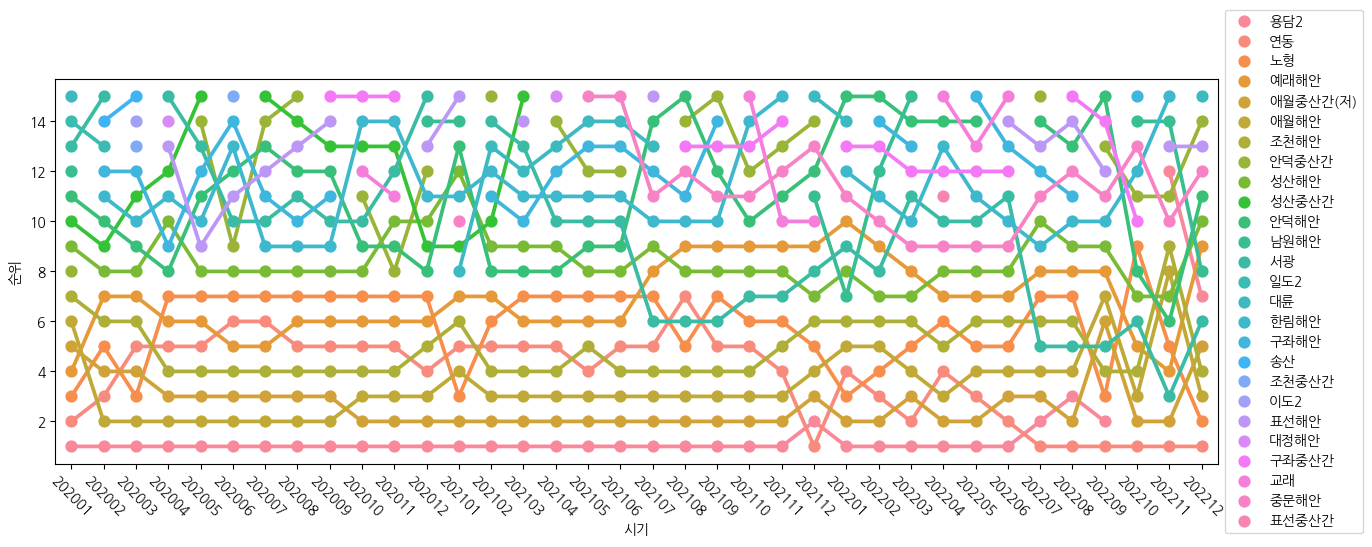

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (15, 5))
sns.pointplot(data = ratio_total, x = '시기', y = '순위', hue = '블록명', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.show()

In [ ]:
ratio_total.sort_values(['블록명', '시기'])

,순위,블록명,비율,시기
146,12,교래,2.2,202010
160,11,교래,2.3,202011
329,15,교래,2.1,202110
339,10,교래,2.5,202111
354,10,교래,2.5,202112
...,...,...,...,...
458,9,한림해안,3,202207
474,10,한림해안,3,202208
489,10,한림해안,2.6,202209
506,12,한림해안,2.6,202210


In [ ]:
ratio_total['블록명'].value_counts()

성산해안        36
노형          36
예래해안        36
애월중산간(저)    36
애월해안        36
조천해안        36
연동          36
용담2         35
안덕해안        35
서광          34
한림해안        33
구좌해안        23
안덕중산간       22
중문해안        21
구좌중산간       16
표선해안        16
성산중산간       14
대륜          11
남원해안        10
교래           8
대정해안         2
일도2          2
조천중산간        2
송산           2
이도2          1
표선중산간        1
Name: 블록명, dtype: int64

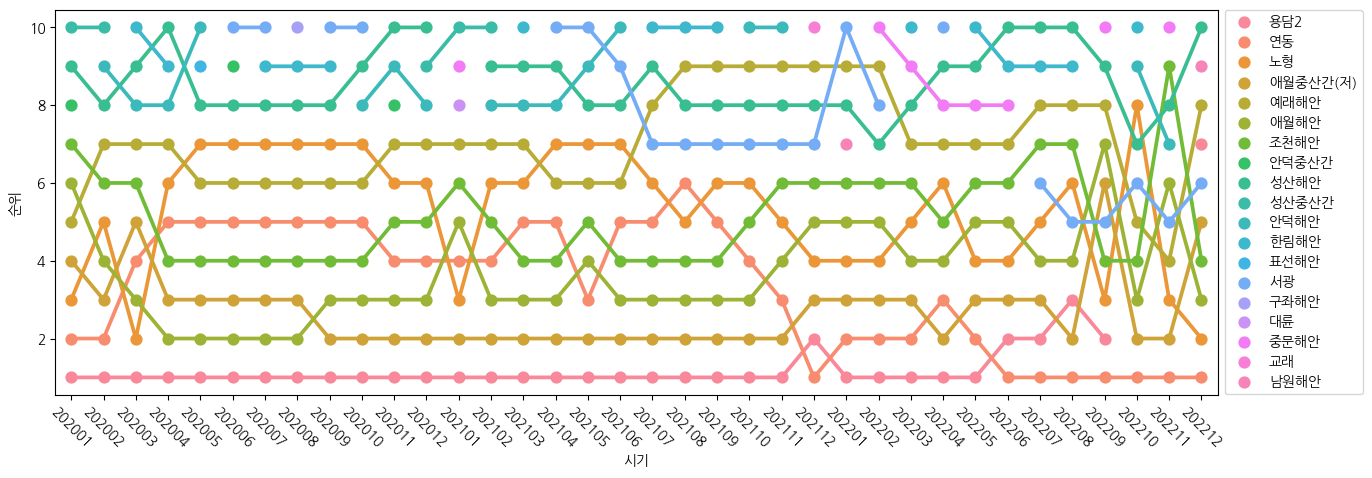

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.pointplot(data = count_male, x = '시기', y = '순위', hue = '블록명', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.show()

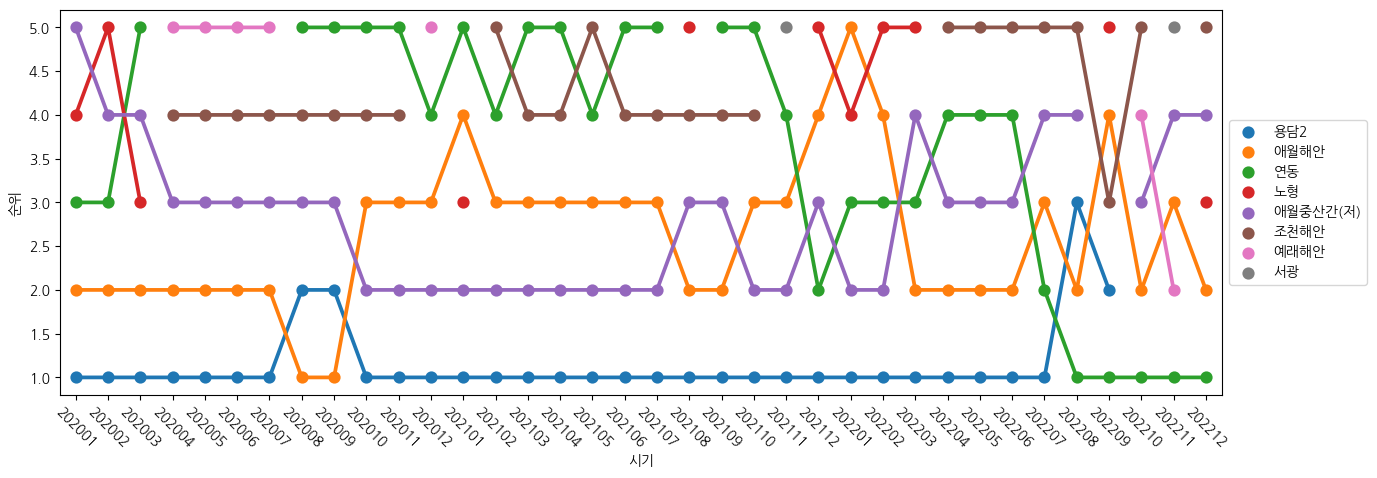

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.pointplot(data = count_2030, x = '시기', y = '순위', hue = '블록명', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.show()

## 지도 이미지 활용 시 다음 코드를 이용하여 png파일로 추출

In [ ]:
for t in YYYYMM:
  parsed = Presentation(DATA_PATH + t + '.pptx')
  for page in slides:
    slide = parsed.slides[page]
    idx = 0
    for shape in slide.shapes:
      if shape.shape_type == MSO_SHAPE_TYPE.PICTURE:
        idx += 1
        image_blob = shape.image.blob # 이미지의 이진 bytestream을 객체에 저장
        ext = shape.image.ext # 이미지의 표준 파일 확장자를 객체에 저장
        with open(f'{DATA_PATH}image/{page+1:02d}/{t}_{idx}.{ext}', 'wb') as file:  # 경로를 지정하여 파일 작성
          file.write(image_blob)

## 월별 입도객 현황 참고

In [19]:
import numpy as np
import pandas as pd
import requests

PATH_2022 = 'https://api.odcloud.kr/api/3083546/v1/uddi:6d8a391a-e30e-4feb-bd74-e5efc804e631'
serviceKey = 'YjwuOSErCt4PB%2BANN4eK26d76AIC6dbwF52v%2FNkCmmZdIi4ZSXRSITMWtc2y%2B%2F8gjL6p4%2FBfiNZgoraqpsihDg%3D%3D'
url = PATH_2022 + '?page=1&perPage=12&serviceKey=' + serviceKey

req = requests.get(url)
json_2022 = req.json()
# json_2022

In [20]:
df_2022 = pd.DataFrame(json_2022['data'])
# df_2022

In [21]:
df_2022['총원'] = df_2022.iloc[:, -3:].sum(axis=1)
df_2022 = df_2022.loc[:, ['구분연월', '총원']]
df_2022[['연', '월']] = df_2022['구분연월'].str.split('-', expand = True)
# df_2022

In [22]:
PATH_2021 = 'https://api.odcloud.kr/api/3083546/v1/uddi:edda6259-c720-4c6e-8b11-f991b9720e34'
serviceKey = 'YjwuOSErCt4PB%2BANN4eK26d76AIC6dbwF52v%2FNkCmmZdIi4ZSXRSITMWtc2y%2B%2F8gjL6p4%2FBfiNZgoraqpsihDg%3D%3D'
url = PATH_2021 + '?page=1&perPage=12&serviceKey=' + serviceKey

req = requests.get(url)
json_2021 = req.json()

df_2021 = pd.DataFrame(json_2021['data'])
df_2021['총원'] = df_2021.iloc[:, -3:].sum(axis=1)
df_2021 = df_2021.loc[:, ['구분연월', '총원']]
df_2021[['연', '월']] = df_2021['구분연월'].str.split('-', expand = True)
# df_2021

In [23]:
PATH_2020 = 'https://api.odcloud.kr/api/3083546/v1/uddi:70b77b60-b9ee-4cd4-ad49-d24626f1af6b'
serviceKey = 'YjwuOSErCt4PB%2BANN4eK26d76AIC6dbwF52v%2FNkCmmZdIi4ZSXRSITMWtc2y%2B%2F8gjL6p4%2FBfiNZgoraqpsihDg%3D%3D'
url = PATH_2020 + '?page=1&perPage=12&serviceKey=' + serviceKey

req = requests.get(url)
json_2020 = req.json()

df_2020 = pd.DataFrame(json_2020['data'])
df_2020['총원'] = df_2020.iloc[:, -3:].sum(axis=1)
df_2020 = df_2020.loc[:, ['구분연월', '총원']]
df_2020[['연', '월']] = df_2020['구분연월'].str.split('-', expand = True)
# df_2020

In [24]:
PATH_2019 = 'https://api.odcloud.kr/api/3083546/v1/uddi:a7bf1e97-d777-4550-8e98-b254dc64d9e6'
serviceKey = 'YjwuOSErCt4PB%2BANN4eK26d76AIC6dbwF52v%2FNkCmmZdIi4ZSXRSITMWtc2y%2B%2F8gjL6p4%2FBfiNZgoraqpsihDg%3D%3D'
url = PATH_2019 + '?page=1&perPage=12&serviceKey=' + serviceKey

req = requests.get(url)
json_2019 = req.json()

df_2019 = pd.DataFrame(json_2019['data'])
df_2019.iloc[:, 2:] = df_2019.iloc[:, 2:].astype('int64')
df_2019['총원'] = df_2019.iloc[:, -3:].sum(axis=1)
df_2019 = df_2019.loc[:, ['구분연월', '총원']]
df_2019[['연', '월']] = df_2019['구분연월'].str.split('-', expand = True)
# df_2019

In [25]:
PATH_2018 = 'https://api.odcloud.kr/api/3083546/v1/uddi:246e7b85-9ecc-4b0d-89d6-9aaff6369813'
serviceKey = 'YjwuOSErCt4PB%2BANN4eK26d76AIC6dbwF52v%2FNkCmmZdIi4ZSXRSITMWtc2y%2B%2F8gjL6p4%2FBfiNZgoraqpsihDg%3D%3D'
url = PATH_2018 + '?page=1&perPage=12&serviceKey=' + serviceKey

req = requests.get(url)
json_2018 = req.json()

df_2018 = pd.DataFrame(json_2018['data'])
df_2018.iloc[:, 2:] = df_2018.iloc[:, 2:].astype('int64')
df_2018['총원'] = df_2018.iloc[:, -3:].sum(axis=1)
df_2018 = df_2018.loc[:, ['구분연월', '총원']]
df_2018[['연', '월']] = df_2018['구분연월'].str.split('-', expand = True)
# df_2018

In [26]:
df_5years = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index = True)
# df_5years

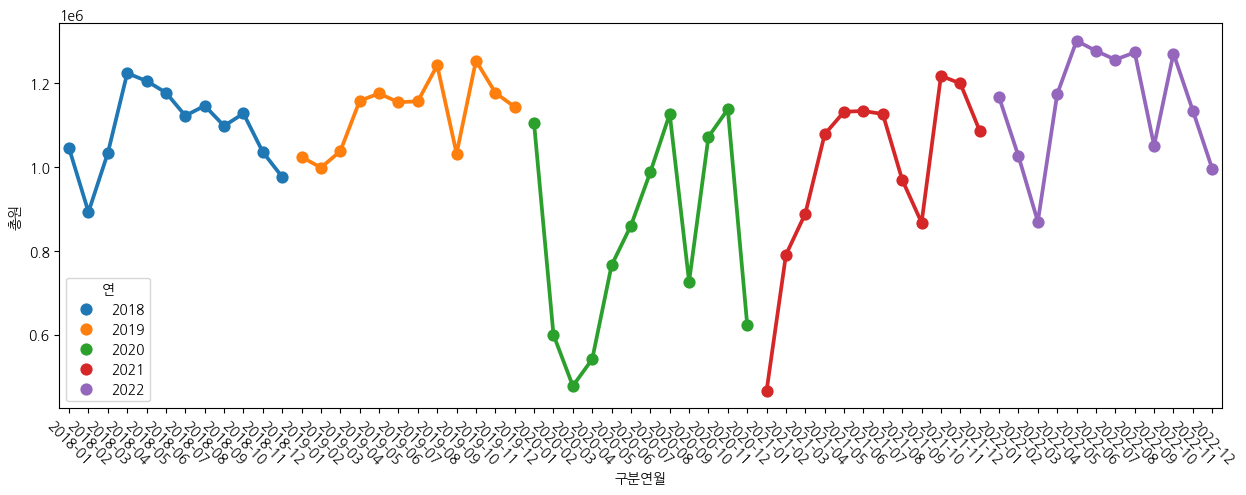

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (15, 5))
sns.pointplot(data = df_5years, x = '구분연월', y = '총원', hue = '연', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)

plt.show()

In [18]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=6a0d71b93efd9614e0416135caa0d6789cfcc974a47520d902b71b387b4a38fb
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


## 가설검정
- 귀무가설: 성수기인 7-8월의 평균 입도객 수는 그 해의 최대 입도객 수와 통계적으로 유의한 차이가 없다.
- 대립가설: 성수기인 7-8월의 평균 입도객 수는 그 해의 최대 입도객 수와 통계적으로 유의한 차이가 있다.

In [44]:
import pingouin as pg

alpha = 0.05
mu_2018 = df_2018['총원'].max()
x_2018 = df_2018.loc[6:7, '총원']
ttest_2018 = pg.ttest(x_2018, mu_2018).round(4)
p_val = float(ttest_2018['p-val'])

if p_val < alpha:
  print(f'p-val {p_val}로 귀무가설을 기각합니다.')
else:
  print(f'p-val {p_val}로 귀무가설을 채택합니다.')

p-val 0.0842로 귀무가설을 채택합니다.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


In [54]:
import pingouin as pg

years = [2018, 2019, 2020, 2021, 2022]
alpha = 0.05

for year in years:
  mu = df_5years.loc[(df_5years['연'] == str(year)), '총원'].max()
  x = df_5years.loc[(df_5years['연'] == str(year)) & ((df_5years['월'] == '07') | (df_5years['월'] == '08')), '총원']
  ttest = pg.ttest(x, mu).round(4)
  p_val = float(ttest['p-val'])

  if p_val < alpha:
    print(f'{year}년의 p-val값은 {p_val}로 귀무가설을 기각합니다.')
  else:
    print(f'{year}년의 p-val값은 {p_val}로 귀무가설을 채택합니다.')

2018년의 p-val값은 0.0842로 귀무가설을 채택합니다.
2019년의 p-val값은 0.4262로 귀무가설을 채택합니다.
2020년의 p-val값은 0.4523로 귀무가설을 채택합니다.
2021년의 p-val값은 0.2758로 귀무가설을 채택합니다.
2022년의 p-val값은 0.1483로 귀무가설을 채택합니다.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7313: RuntimeWarning: divide by zero encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:7321: RuntimeWarning: divide by zero encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:73

- 연도별 표본이 7월과 8월로 표본의 크기가 2개 밖에 되지 않아 중심극한정리에 따른 정규성을 사용할 수 없고
- shapiro test 또한 표본 크기가 최소 3이 되어야 한다고 하기 때문에
- 비모수검정 진행?

In [58]:
wilcox_2018 = x_2018 - mu_2018
pg.wilcoxon(wilcox_2018)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.5,-1.0,NaN


In [59]:
years = [2018, 2019, 2020, 2021, 2022]
alpha = 0.05

for year in years:
  mu = df_5years.loc[(df_5years['연'] == str(year)), '총원'].max()
  x = df_5years.loc[(df_5years['연'] == str(year)) & ((df_5years['월'] == '07') | (df_5years['월'] == '08')), '총원']
  wilcox = pg.wilcoxon(x - mu).round(4)
  p_val = float(wilcox['p-val'])

  if p_val < alpha:
    print(f'{year}년의 p-val값은 {p_val}로 귀무가설을 기각합니다.')
  else:
    print(f'{year}년의 p-val값은 {p_val}로 귀무가설을 채택합니다.')

2018년의 p-val값은 0.5로 귀무가설을 채택합니다.
2019년의 p-val값은 0.5로 귀무가설을 채택합니다.
2020년의 p-val값은 0.5로 귀무가설을 채택합니다.
2021년의 p-val값은 0.5로 귀무가설을 채택합니다.
2022년의 p-val값은 0.5로 귀무가설을 채택합니다.
